In [1]:
import pandas as pd
import pymysql,re

host = "127.0.0.1"
port = "3306"
user = "root"
password = ""
database = "digital_talent"

conn = pymysql.connect(
    host=host,
    port=int(port),
    user=user,
    passwd=password,
    db=database,
    charset='utf8mb4')
    
def run(sql):
    df = pd.read_sql_query(sql,conn)
    return df

news = run("SELECT * FROM event_election_new WHERE title != 'not found'")

news.head()

,waktu,url,tone,title,content,Sentiment
0,2018-08-10,http://en.qantara.de/content/indonesias-joko-w...,0.000000,indonesia's joko widodo names muslim cleric as...,indonesia's joko widodo names muslim cleric as...,Neutral
1,2018-06-06,http://en.republika.co.id/berita/en/national-p...,2.721088,it hurts to see elections split the community:...,jokowi says indonesia is respected abroad for ...,Positive
2,2018-08-18,http://jakartaglobe.id/human-rights-news/democ...,-5.913979,democratic maturity will ensure peaceful elect...,the president also highlighted the role of sta...,Negative
3,2018-08-16,http://jakartaglobe.id/news/democratic-maturit...,-5.913979,democratic maturity will ensure peaceful elect...,the president also highlighted the role of sta...,Negative
4,2018-08-09,http://jakartaglobe.id/news/islamic-scholar-ma...,2.647059,islamic scholar ma'ruf amin becomes jokowi's r...,president joko 'jokowi' widodo has chosen ma'r...,Positive


In [2]:
import numpy as np
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [3]:
print news['title'][:10] #first 10 titles

0    indonesia's joko widodo names muslim cleric as...
1    it hurts to see elections split the community:...
2    democratic maturity will ensure peaceful elect...
3    democratic maturity will ensure peaceful elect...
4    islamic scholar ma'ruf amin becomes jokowi's r...
5    jokowi and ma'ruf undergo medical exams in pre...
6      eye on re election, widodo plays the islam card
7        widodo’s re election strategy comes into view
8    having visited gus dur’s family, pkb believes ...
9    indonesia’s 2018 regional elections: regional ...
Name: title, dtype: object


In [4]:
print news.content[0][:200] #first 200 characters in first title
print
print

indonesia's joko widodo names muslim cleric as election running mate indonesian president joko widodo said on thursday he has picked a muslim cleric as his running mate for next year's election, in wh




# Stopwords, stemming, tokenizing

In [5]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [6]:
print stopwords[:10]

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u"you're"]


In [7]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [8]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [9]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in news.content:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [10]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print 'there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame'

there are 26129 items in vocab_frame


In [11]:
print vocab_frame.head()
print
print
print
print

               words
indonesia  indonesia
's                's
joko            joko
widodo        widodo
name           names






# TfIdf and document similarity

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(news.content) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

C:\Users\LENOVO\Anaconda2\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [u'abov', u'afterward', u'alon', u'alreadi', u'alway', u'ani', u'anoth', u'anyon', u'anyth', u'anywher', u'becam', u'becaus', u'becom', u'befor', u'besid', u'cri', u'describ', u'dure', u'els', u'elsewher', u'empti', u'everi', u'everyon', u'everyth', u'everywher', u'fifti', u'forti', u'henc', u'hereaft', u'herebi', u'howev', u'hundr', u'inde', u'mani', u'meanwhil', u'moreov', u'nobodi', u'noon', u'noth', u'nowher', u'onc', u'onli', u'otherwis', u'ourselv', u'perhap', u'pleas', u'sever', u'sinc', u'sincer', u'sixti', u'someon', u'someth', u'sometim', u'somewher', u'themselv', u'thenc', u'thereaft', u'therebi', u'therefor', u'togeth', u'twelv', u'twenti', u'veri', u'whatev', u'whenc', u'whenev', u'wherea', u'whereaft', u'wherebi', u'wherev', u'whi', u'yourselv'] not in stop_words.
  'stop_wo

Wall time: 4.99 s
(44, 276)


In [13]:
terms = tfidf_vectorizer.get_feature_names()

In [14]:
terms[:10]

[u"'s",
 u'accord',
 u'ad',
 u'administr',
 u'advisori',
 u'agus',
 u'ahead',
 u'amin',
 u'analyst',
 u'ani']

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print
print

# KMeans Clustering

In [16]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 3.83 s


In [17]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_clusterkm.pkl')

km = joblib.load('doc_clusterkm.pkl')
clusters = km.labels_.tolist()

In [18]:
title = list(news.title)
tone = list(news.tone)
content = list(news.content)

In [19]:
data = { 'title': title, 'tone' : tone, 'content': content, 'cluster': clusters}

frame = pd.DataFrame(data, index = [clusters] , columns = ['cluster','title','content','tone'])
frame.head()

,cluster,title,content,tone
2,2,indonesia's joko widodo names muslim cleric as...,indonesia's joko widodo names muslim cleric as...,0.000000
2,2,it hurts to see elections split the community:...,jokowi says indonesia is respected abroad for ...,2.721088
4,4,democratic maturity will ensure peaceful elect...,the president also highlighted the role of sta...,-5.913979
4,4,democratic maturity will ensure peaceful elect...,the president also highlighted the role of sta...,-5.913979
2,2,islamic scholar ma'ruf amin becomes jokowi's r...,president joko 'jokowi' widodo has chosen ma'r...,2.647059


In [20]:
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

3    13
2    13
1     9
4     5
0     4
Name: cluster, dtype: int64

In [21]:
grouped = frame['tone'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

grouped.mean() #average rank (1 to 100) per cluster

cluster
0   -5.622966
1    1.852627
2    0.356357
3    0.182398
4   -5.921321
Name: tone, dtype: float64

In [22]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: government, outside, risk, visited, another, history, 's, criticized, efforts, nationalist,

Cluster 0 titles: indonesian disaster raises risks for president widodo as he eyes re election, indonesian disaster raises risks for president widodo as he eyes re election, indonesian disaster raises risks for president widodo as he eyes re election, ‘next few days critical’ president widodo under pressure,

Cluster 1 words: java, s, west, west, parties, jokowi, regional, east, support, vote,

Cluster 1 titles: widodo’s re election strategy comes into view, indonesia’s 2018 regional elections: regional setback for jokowi? – analysis, will joko widodo’s campaigning pay off in west java election, a bellwether of indonesia’s voters?, why west java election matters to jokowi, prabowo, jokowi congratulates timor leste for successful parliamentary election, parawansa to support jokowi amin pair in 2019 presidential election, indonesia provincial elections poi

# Multidimensional Scaling

In [23]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

# Visualizing

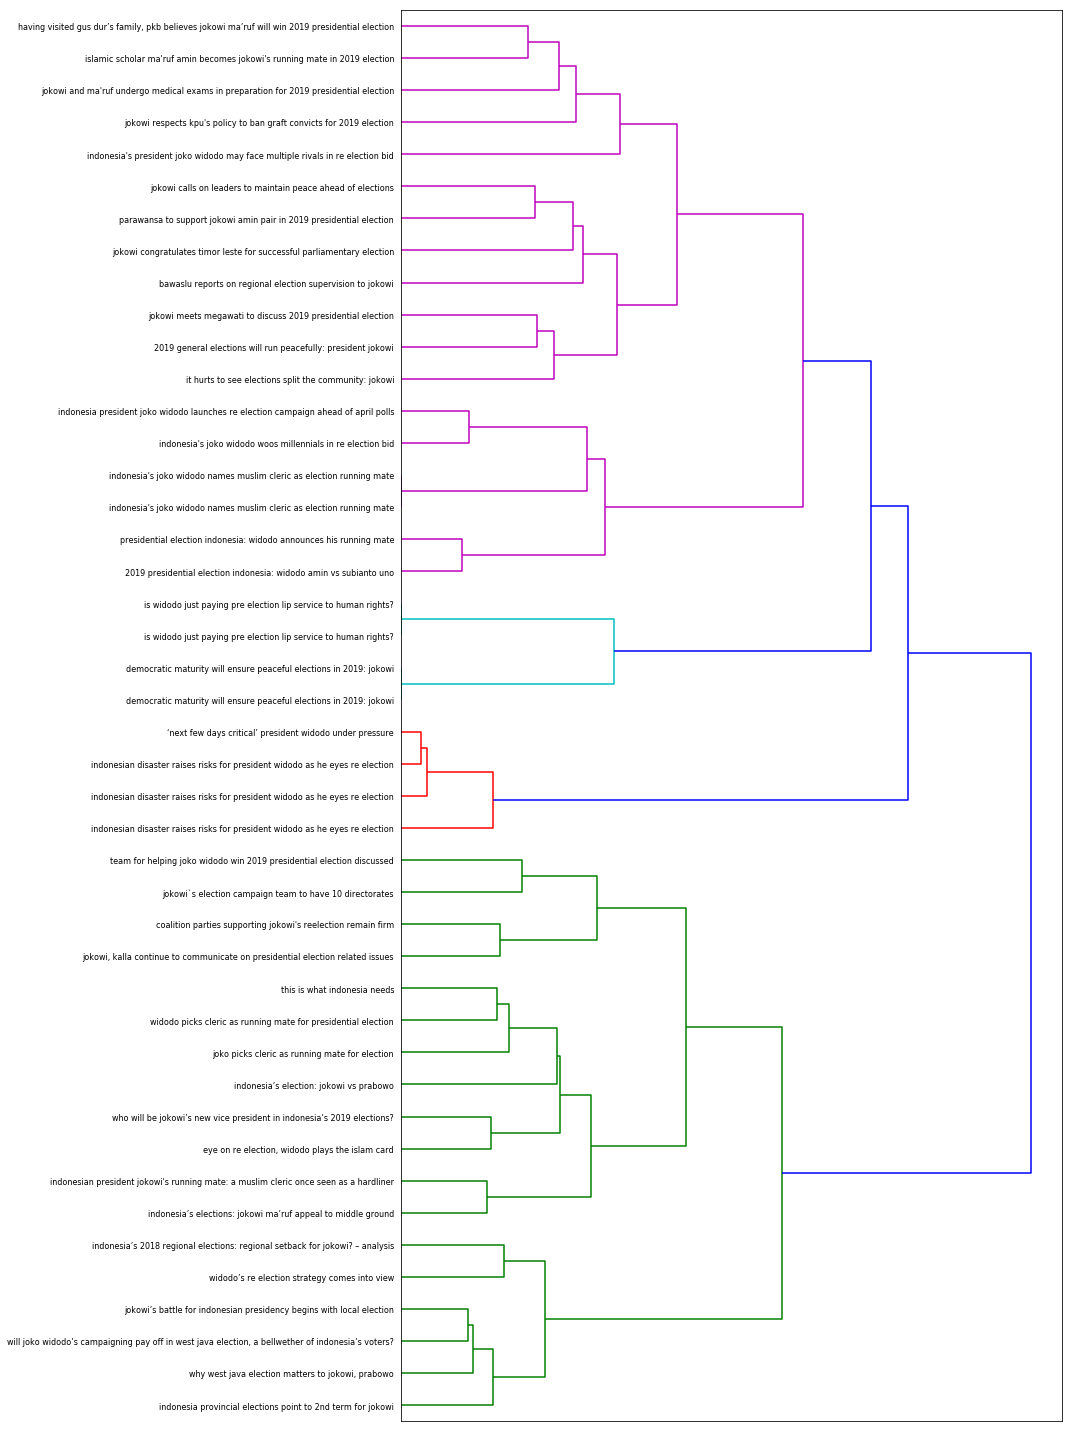

In [24]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=frame.title);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [25]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'government, outside, risk', 
                 1: 'java,parties,jokowi', 
                 2: 'candidate,running,mate', 
                 3: 'jokowi,indonesia,political', 
                 4: 'human,right,administration'}

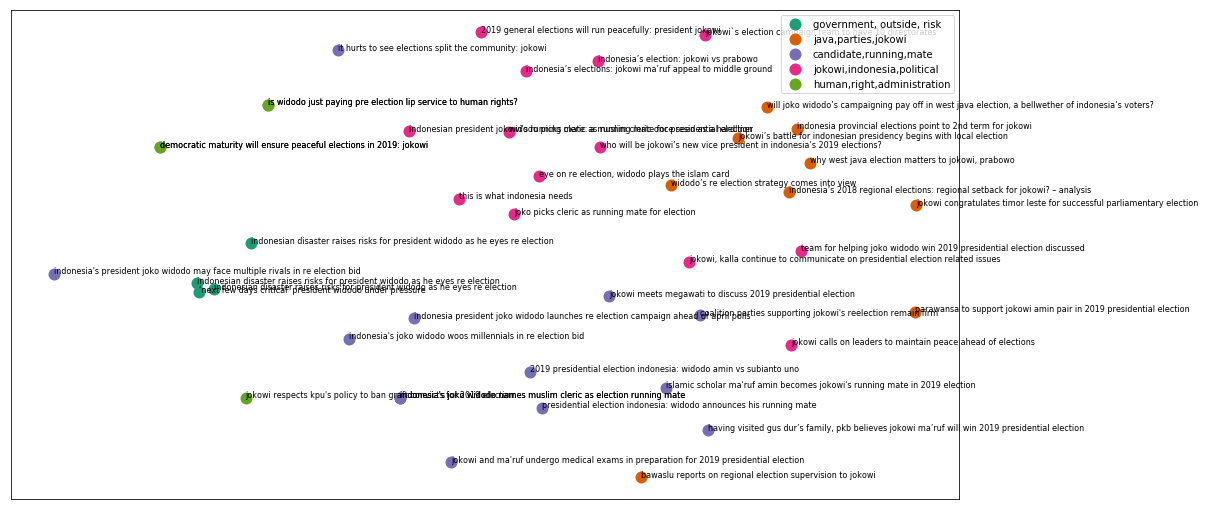

In [26]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=news.title)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)

In [27]:
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [28]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=news.title)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

# DBSCAN

In [46]:
from sklearn.cluster import DBSCAN

# num_clusters = 5

dbscan = DBSCAN(eps=0.9)

%time dbscan.fit(tfidf_matrix)

clusters = dbscan.labels_.tolist()

Wall time: 10 ms


In [47]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(dbscan,  'doc_cluster7.pkl')

dbscan = joblib.load('doc_cluster7.pkl')
clusters = dbscan.labels_.tolist()

In [48]:
title = list(news.title)
tone = list(news.tone)
content = list(news.content)

In [49]:
data = { 'title': title, 'tone' : tone, 'content': content, 'cluster': clusters}

frame = pd.DataFrame(data, index = [clusters] , columns = ['cluster','title','content','tone'])
frame.head()

,cluster,title,content,tone
-1,-1,indonesia's joko widodo names muslim cleric as...,indonesia's joko widodo names muslim cleric as...,0.000000
-1,-1,it hurts to see elections split the community:...,jokowi says indonesia is respected abroad for ...,2.721088
-1,-1,democratic maturity will ensure peaceful elect...,the president also highlighted the role of sta...,-5.913979
-1,-1,democratic maturity will ensure peaceful elect...,the president also highlighted the role of sta...,-5.913979
-1,-1,islamic scholar ma'ruf amin becomes jokowi's r...,president joko 'jokowi' widodo has chosen ma'r...,2.647059


In [50]:
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

-1    35
 0     9
Name: cluster, dtype: int64

In [51]:
grouped = frame['tone'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

grouped.mean() #average rank (1 to 100) per cluster

cluster
-1   -1.107998
 0    1.150989
Name: tone, dtype: float64

In [52]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

num_clusters = 5
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: government, outside, risk, visited, another, history, 's, criticized, efforts, nationalist,

Cluster 0 titles: eye on re election, widodo plays the islam card, widodo’s re election strategy comes into view, indonesia’s 2018 regional elections: regional setback for jokowi? – analysis, will joko widodo’s campaigning pay off in west java election, a bellwether of indonesia’s voters?, why west java election matters to jokowi, prabowo, jokowi, kalla continue to communicate on presidential election related issues, who will be jokowi’s new vice president in indonesia’s 2019 elections?, indonesia provincial elections point to 2nd term for jokowi, jokowi’s battle for indonesian presidency begins with local election,

Cluster 1 words: java, s, west, west, parties, jokowi, regional, east, support, vote,

Cluster 1 titles:

KeyError: u'the label [1] is not in the [index]'

# Multidimensional Scaling

In [53]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

# Visualizing

In [57]:
# #set up colors per clusters using a dict
# cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

# #set up cluster names using a dict
# cluster_names = {0: 'government, outside, risk', 
#                  -1: 'human, rights, administration'}

In [58]:
# #some ipython magic to show the matplotlib plots inline
# %matplotlib inline 

# #create data frame that has the result of the MDS plus the cluster numbers and titles
# df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=news.title)) 

# #group by cluster
# groups = df.groupby('label')


# # set up plot
# fig, ax = plt.subplots(figsize=(17, 9)) # set size
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# #iterate through groups to layer the plot
# #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
# for name, group in groups:
#     ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#             label=cluster_names[name], color=cluster_colors[name], 
#             mec='none')
#     ax.set_aspect('auto')
#     ax.tick_params(\
#         axis= 'x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom='off',      # ticks along the bottom edge are off
#         top='off',         # ticks along the top edge are off
#         labelbottom='off')
#     ax.tick_params(\
#         axis= 'y',         # changes apply to the y-axis
#         which='both',      # both major and minor ticks are affected
#         left='off',      # ticks along the bottom edge are off
#         top='off',         # ticks along the top edge are off
#         labelleft='off')
    
# ax.legend(numpoints=1)  #show legend with only 1 point

# #add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
# plt.show() #show the plot

# #uncomment the below to save the plot if need be
# plt.savefig('clusters_small_noaxes2.png', dpi=200)

In [59]:
# from scipy.cluster.hierarchy import ward, dendrogram

# linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

# fig, ax = plt.subplots(figsize=(15, 20)) # set size
# ax = dendrogram(linkage_matrix, orientation="right", labels=frame.title);

# plt.tick_params(\
#     axis= 'x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     labelbottom='off')

# plt.tight_layout() #show plot with tight layout

# #uncomment below to save figure
# plt.savefig('ward_clusters2.png', dpi=200) #save figure as ward_clusters

In [60]:
# class TopToolbar(mpld3.plugins.PluginBase):
#     """Plugin for moving toolbar to top of figure"""

#     JAVASCRIPT = """
#     mpld3.register_plugin("toptoolbar", TopToolbar);
#     TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
#     TopToolbar.prototype.constructor = TopToolbar;
#     function TopToolbar(fig, props){
#         mpld3.Plugin.call(this, fig, props);
#     };

#     TopToolbar.prototype.draw = function(){
#       // the toolbar svg doesn't exist
#       // yet, so first draw it
#       this.fig.toolbar.draw();

#       // then change the y position to be
#       // at the top of the figure
#       this.fig.toolbar.toolbar.attr("x", 150);
#       this.fig.toolbar.toolbar.attr("y", 400);

#       // then remove the draw function,
#       // so that it is not called again
#       this.fig.toolbar.draw = function() {}
#     }
#     """
#     def __init__(self):
#         self.dict_ = {"type": "toptoolbar"}

In [61]:
# #create data frame that has the result of the MDS plus the cluster numbers and titles
# df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=news.title)) 

# #group by cluster
# groups = df.groupby('label')

# #define custom css to format the font and to remove the axis labeling
# css = """
# text.mpld3-text, div.mpld3-tooltip {
#   font-family:Arial, Helvetica, sans-serif;
# }

# g.mpld3-xaxis, g.mpld3-yaxis {
# display: none; }

# svg.mpld3-figure {
# margin-left: -200px;}
# """

# # Plot 
# fig, ax = plt.subplots(figsize=(14,6)) #set plot size
# ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

# #iterate through groups to layer the plot
# #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
# for name, group in groups:
#     points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
#                      label=cluster_names[name], mec='none', 
#                      color=cluster_colors[name])
#     ax.set_aspect('auto')
#     labels = [i for i in group.title]
    
#     #set tooltip using points, labels and the already defined 'css'
#     tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
#                                        voffset=10, hoffset=10, css=css)
#     #connect tooltip to fig
#     mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
#     #set tick marks as blank
#     ax.axes.get_xaxis().set_ticks([])
#     ax.axes.get_yaxis().set_ticks([])
    
#     #set axis as blank
#     ax.axes.get_xaxis().set_visible(False)
#     ax.axes.get_yaxis().set_visible(False)

    
# ax.legend(numpoints=1) #show legend with only one dot

# mpld3.display() #show the plot

# #uncomment the below to export to html
# #html = mpld3.fig_to_html(fig)
# #print(html)

In [62]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(tfidf_matrix)
pca_2d = pca.transform(tfidf_matrix)

for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif dbscan.labels_[i] == -1:
        c8 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')

fig = plt.figure(1)
plt.legend([c1, c2, c3, c4], ['Cluster 1','Noise'])
plt.title('DBSCAN finds clusters and noise')
plt.show()
fig.savefig("dbscan2.png", dpi=900)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [65]:
from sklearn.metrics import davies_bouldin_score
X=tfidf_matrix.toarray()
labels=dbscan.labels_
print(davies_bouldin_score(X, labels))

2.54660233092


C:\Users\LENOVO\Anaconda2\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [66]:
from sklearn.metrics import davies_bouldin_score
X=tfidf_matrix.toarray()
labels=km.labels_
print(davies_bouldin_score(X, labels))

2.15306417453
